#  Iterate Destination Hosts and associated Ports, over time periods, to create an Analytical Data Set &nbsp;&nbsp; for the Out-Degree Entropy model

In [1]:
# use print only as a function
from __future__ import print_function
import sys
sys.version

'2.7.9 (default, Jun 29 2016, 13:08:31) \n[GCC 4.9.2]'

## Connect to data and read into dataframe

In [2]:
__author__ = 'swe03'

import numpy as np
import pandas as pd
import pandas.io.gbq as pdg
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from decimal import *
import re 

import statsmodels.tsa as tsa

from statsmodels.tsa.stattools import ccf 
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.base import datetools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats.stats import pearsonr

from sklearn import linear_model

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from scipy import stats

from datetime import datetime, timedelta

desired_width = 250
pd.set_option('display.width',desired_width)
pd.set_option('display.max_rows', 500)

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from elasticsearch import Elasticsearch      # This was installed successfully after the pip install above
from elasticsearch import helpers
from elasticsearch_dsl import Search, Q     # This was installed successfully after the pip install above

###### Install the SQL package if not already installed 

In [4]:
#!pip install pandasql

In [5]:
from pandasql import PandaSQL 
pdsql = PandaSQL()

In [6]:
## Establish the connection to the Elastic Search host/port
es = Elasticsearch(hosts=[{"host":'10.43.40.49', "port":9200}])     ## Prod
#es = Elasticsearch(hosts=[{"host":'10.43.43.196', "port":9200}])     ## Dev

##### Use an existing table but change the timestamps to create a contiguous distribution.
##### Note that for the Out-Degree Entropy the list of servers that were the Destination, for In-Degree, are now the Source of the communication. 
##### Also note that the references to "host" in subsequent functions can either be src or dst

In [33]:
def Get_recs_w_date_range(start_dt):
    global query_result
    query_result = {"query":{
                      "bool": {
                        "must": [{"term": {"flStDttmEst": start_dt}}
                                ],               
                        "filter": [
                                #{"term": {"proto": "6"}},
                                {"terms": {"proto": ["6","17"]}},
                                {"terms": {"srcAd": ["165.130.217.229", "165.130.217.228","165.130.217.225","165.130.217.226","165.130.217.227",
                                                     "165.130.217.228","165.130.217.229","165.130.217.230","165.130.217.231","165.130.217.232",
                                                     "165.130.217.233","165.130.217.234","165.130.217.235","165.130.217.236","165.130.217.237",
                                                     "165.130.217.238"]}}
                                  ]
                               }
                             }
                   }
    return 

#date_start = "2017-06-11 10:00:00"

#Get_recs_w_date_range(date_start)

In [8]:
#print(query_result)

In [9]:
### This is a diagnostic cell to confirm that the query_result is valid
def skip():
    result = helpers.scan(es,query=query_result,index='ipfix-5min-20170611',scroll='1m') 
    final_list = []

    if result:
      for res in result:
        final_list.append(res['_source'])

    dataframe2 = pd.DataFrame.from_records(final_list)
    dataframe2

In [13]:
def Initialize_and_Iterate():
  date_start_t = pd.to_datetime("2017-06-11 10:00:00")
  date_end_interval = "2017-06-11 11:00:00"
  scroll_count = 0
  
  while date_start_t <= pd.to_datetime(date_end_interval):
    #date_end = date_start + timedelta(minutes=59,seconds=59)   # Set the date_end of the hour interval
    print('For get_recs function date_start_t=',date_start_t)
    scroll_count = scroll_count + 1
    
    date_start = str(date_start_t)
    print('date_start = ', date_start)
    
    Get_recs_w_date_range(date_start) 
    #print("after the Get_recs. query_result = ",query_result)
    Scroll(scroll_count)
    #print("after the Scroll",final_df)
    
    date_start_t = date_start_t+ timedelta(minutes=5)           # Add a second to the nn:59:59 end date to start the next # hour on nn:00:00 start time
      
  return      

#Initialize_and_Iterate()

#print(date_start)

In [14]:
def Scroll(scroll_cnt):
    global final_df
    global final_df2
    #result = helpers.scan(es,query=query_result,index='ipfix-5min-20170611',scroll='2m')    ### This is time units so 1m is one minute  
    result = helpers.scan(es,query=query_result,index='ipfix-5min-20170611',scroll='1m')     
    #print("in the Scroll. query_result = ",query_result)
     
    final_list = []    
    
    
    #print("before the if result. final_list = ", final_list)
 
    #if result:
    #    for res in result:
    #        final_list.append(res['_source'])
    #        #print("In the for res loop. result address = ", result)
    ##print("after the if result. final_list = ", final_list)      
    #dataframe1 = pd.DataFrame.from_records(final_list) 
    ##print("after the dataframe1 assignment. dataframe1 = ", dataframe1)
    #final_df = final_df.append(dataframe1) 
    
    if result:
      count = 0
      
      for res in result:
        final_list.append(res['_source'])
        count = count + 1
        if count == 100:
            break
          
    dataframe1 = pd.DataFrame.from_records(final_list) 
    final_df = final_df.append(dataframe1) 
    del dataframe1  
    return 

#Scroll()
#dataframe1

In [15]:
def Create_date_hour():
  global final_df
  final_df.EventDT = pd.to_datetime(final_df.flStDttmEst)
  final_df['date_hour'] = final_df.EventDT.dt.strftime('%Y-%m-%d-%H')  # creates a Series with Date and Hour
  final_df['date_hour'] = pd.to_datetime(final_df['date_hour'] )
  final_df.reset_index(drop=True, inplace=True)
  return 

### Initiate the Process

##### Call the functions

In [35]:
final_df = pd.DataFrame()              # Create the df that will be appended to each timeframe
Initialize_and_Iterate()           # For each Host/Port, iterate through the timeframes 
#Create_date_hour()                 # Create a Day/Hour variable for the final, appended df

For get_recs function date_start_t= 2017-06-11 10:00:00
date_start =  2017-06-11 10:00:00
For get_recs function date_start_t= 2017-06-11 10:05:00
date_start =  2017-06-11 10:05:00
For get_recs function date_start_t= 2017-06-11 10:10:00
date_start =  2017-06-11 10:10:00
For get_recs function date_start_t= 2017-06-11 10:15:00
date_start =  2017-06-11 10:15:00
For get_recs function date_start_t= 2017-06-11 10:20:00
date_start =  2017-06-11 10:20:00
For get_recs function date_start_t= 2017-06-11 10:25:00
date_start =  2017-06-11 10:25:00
For get_recs function date_start_t= 2017-06-11 10:30:00
date_start =  2017-06-11 10:30:00
For get_recs function date_start_t= 2017-06-11 10:35:00
date_start =  2017-06-11 10:35:00
For get_recs function date_start_t= 2017-06-11 10:40:00
date_start =  2017-06-11 10:40:00
For get_recs function date_start_t= 2017-06-11 10:45:00
date_start =  2017-06-11 10:45:00
For get_recs function date_start_t= 2017-06-11 10:50:00
date_start =  2017-06-11 10:50:00
For get_re

In [36]:
desc_stats1 = pdsql("""SELECT d.flStDttmEst, count(d.flStDttmEst) as DT_cnt 
                  from final_df d
                  group by d.flStDttmEst
                  order by d.flStDttmEst""",locals())
desc_stats1

,flStDttmEst,DT_cnt
0,2017-06-11 10:00:00,100
1,2017-06-11 10:05:00,100
2,2017-06-11 10:10:00,100
3,2017-06-11 10:15:00,100
4,2017-06-11 10:20:00,100
5,2017-06-11 10:25:00,100
6,2017-06-11 10:30:00,100
7,2017-06-11 10:35:00,100
8,2017-06-11 10:40:00,100
9,2017-06-11 10:45:00,100


In [37]:
ext1 = final_df.loc[(final_df['flStDttmEst'] == '2017-06-11 10:00:00'),['flStDttmEst','srcAd','srcPt','dstAd','dstPt','proto','flCnt','smOcts','smPkts','smACK','smSYN','smRST' ]]
ext1 = ext1.sort_values(['flStDttmEst', 'srcAd', 'dstAd'],ascending=True)
ext1

,flStDttmEst,srcAd,srcPt,dstAd,dstPt,proto,flCnt,smOcts,smPkts,smACK,smSYN,smRST
0,2017-06-11 10:00:00,165.130.217.227,34395,165.130.1.9,53,17,1,64,1,0,0,0
14,2017-06-11 10:00:00,165.130.217.227,46918,165.130.1.9,53,17,1,55,1,0,0,0
15,2017-06-11 10:00:00,165.130.217.227,7111,165.130.1.9,53,17,1,64,1,0,0,0
70,2017-06-11 10:00:00,165.130.217.227,24118,165.130.1.9,53,17,1,64,1,0,0,0
56,2017-06-11 10:00:00,165.130.217.227,443,172.29.165.66,13421,6,1,1202,8,1,1,0
13,2017-06-11 10:00:00,165.130.217.228,46399,165.130.1.9,53,17,1,55,1,0,0,0
21,2017-06-11 10:00:00,165.130.217.228,23196,165.130.1.9,53,17,1,55,1,0,0,0
26,2017-06-11 10:00:00,165.130.217.228,44840,165.130.1.9,53,17,1,55,1,0,0,0
31,2017-06-11 10:00:00,165.130.217.228,45897,165.130.1.9,53,17,1,55,1,0,0,0
47,2017-06-11 10:00:00,165.130.217.228,8672,165.130.1.9,53,17,1,64,1,0,0,0


In [76]:
### Confirm Unique Src Count (unq_src_count) below
ext3 = final_df.loc[(final_df['flStDttmEst'] == '2017-06-11 10:00:00') & (final_df['dstAd'] == '172.29.236.82'),['flStDttmEst','srcAd','srcPt','dstAd','dstPt','proto','flCnt','smOcts','smPkts','smACK','smSYN','smRST' ]]
ext3 = ext3.sort_values(['flStDttmEst', 'srcAd'],ascending=True)
ext3

,flStDttmEst,srcAd,srcPt,dstAd,dstPt,proto,flCnt,smOcts,smPkts,smACK,smSYN,smRST
3,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,12321,6,1,37250,39,1,1,0
7,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,35067,6,1,16960,22,1,1,1
25,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,42679,6,1,37290,40,1,1,0
28,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,17824,6,1,944,12,1,1,1
39,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,63038,6,1,944,12,1,1,1
41,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,45898,6,1,37290,40,1,1,0
55,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,63611,6,1,37290,40,1,1,0
74,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,18091,6,1,37250,39,1,1,0
77,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,57673,6,1,37290,40,1,1,0
88,2017-06-11 10:00:00,165.130.217.229,443,172.29.236.82,46676,6,1,944,12,1,1,1


In [74]:
### Confirmation for dstAd Unique values
ext2 = ext1.sort_values(['flStDttmEst','dstAd'],ascending=True)
ext2

,flStDttmEst,srcAd,srcPt,dstAd,dstPt,proto,flCnt,smOcts,smPkts,smACK,smSYN,smRST
8,2017-06-11 10:00:00,165.130.217.235,60310,10.74.34.14,9997,6,1,168,4,1,1,0
36,2017-06-11 10:00:00,165.130.217.231,1270,151.140.106.25,49701,6,1,7430,12,1,1,0
83,2017-06-11 10:00:00,165.130.217.231,1270,151.140.106.25,64505,6,1,3814,10,1,1,0
44,2017-06-11 10:00:00,165.130.217.229,1270,151.140.106.26,52660,6,1,4998,10,1,1,0
67,2017-06-11 10:00:00,165.130.217.229,1270,151.140.106.26,53322,6,1,29480,27,1,1,0
84,2017-06-11 10:00:00,165.130.217.229,1270,151.140.106.26,52665,6,1,5438,11,1,1,0
86,2017-06-11 10:00:00,165.130.217.229,1270,151.140.106.26,52703,6,1,7430,12,1,1,0
0,2017-06-11 10:00:00,165.130.217.227,34395,165.130.1.9,53,17,1,64,1,0,0,0
14,2017-06-11 10:00:00,165.130.217.227,46918,165.130.1.9,53,17,1,55,1,0,0,0
15,2017-06-11 10:00:00,165.130.217.227,7111,165.130.1.9,53,17,1,64,1,0,0,0


### Create the Behaviorial Metrics (i.e., Out-Degree Entropy measures)

In [38]:
## Total Unique Dest Hosts during the Time Period
## The "out-degree" is basically the same as in-degree but now the view is what dest hosts are HD src hosts contacting. 
## Values below are confirmed
host_count=final_df.groupby(['flStDttmEst']).dstAd.nunique()    ## This creates a Series
host_count

flStDttmEst
2017-06-11 10:00:00     9
2017-06-11 10:05:00    12
2017-06-11 10:10:00    15
2017-06-11 10:15:00    16
2017-06-11 10:20:00    13
2017-06-11 10:25:00    15
2017-06-11 10:30:00    14
2017-06-11 10:35:00    13
2017-06-11 10:40:00    16
2017-06-11 10:45:00    12
2017-06-11 10:50:00    14
2017-06-11 10:55:00     9
2017-06-11 11:00:00    13
Name: dstAd, dtype: int64

In [39]:
## Total Unique Source Hosts during the Time Period
### Same as above but just creating the dataframe
host_count_df = pdsql("""Select * from host_count""", locals())   ## host_count is a Series
host_count_df['dstAd'] = host_count_df.dstAd.astype(float)
host_count_df                                             ## Dataframe has cols:  date_hour, srcAd (which are the unique counts)

,flStDttmEst,dstAd
0,2017-06-11 10:00:00,9.0
1,2017-06-11 10:05:00,12.0
2,2017-06-11 10:10:00,15.0
3,2017-06-11 10:15:00,16.0
4,2017-06-11 10:20:00,13.0
5,2017-06-11 10:25:00,15.0
6,2017-06-11 10:30:00,14.0
7,2017-06-11 10:35:00,13.0
8,2017-06-11 10:40:00,16.0
9,2017-06-11 10:45:00,12.0


In [40]:
### Number of Unique Source Hosts that connect to each Unique Destination Host
### Note that for these two Source Hosts, from the extraction, there is no variation below and this is creating the 0 values in the final
### Entropy calculation.
##### ENTROPY IS ZERO when 1 outcome is certain
##### Thus, in this limited extract, each of the HD src hosts has it's own mutually exclusive set of dest hosts that it connects. 
##### These two sets of dest hosts are not shared between the two src hosts.
##### Dest host ..106.26 is contacted by a single unique src host 
unq_src_count=final_df.groupby(['flStDttmEst','dstAd']).srcAd.nunique()    ## This creates a Series
unq_src_count

flStDttmEst          dstAd          
2017-06-11 10:00:00  10.74.34.14        1
                     151.140.106.25     1
                     151.140.106.26     1
                     165.130.1.9        2
                     165.130.144.229    1
                     172.29.165.66      1
                     172.29.167.66      1
                     172.29.236.82      3
                     172.29.237.82      3
2017-06-11 10:05:00  10.74.34.22        1
                     151.140.105.200    1
                     151.140.106.25     1
                     151.140.106.26     1
                     151.140.78.180     1
                     151.140.78.210     1
                     165.130.1.9        1
                     165.130.144.227    1
                     165.130.144.229    1
                     172.29.167.66      1
                     172.29.236.82      3
                     172.29.237.82      3
2017-06-11 10:10:00  10.74.34.19        1
                     10.74.34.33       

In [41]:
unq_src_count_df = pdsql("""Select * from unq_src_count""", locals())   ## unq_src_count is a Series

In [42]:
## New
## There's no variation within each of the 5 minute periods for the unq_src_addr_cnt when the server list is small
calc_ent1 = pdsql("""SELECT s.flStDttmEst, s.srcAd as unq_src_addr_cnt, count(srcAd) as xi_cnt 
                  from unq_src_count_df s
                  group by s.flStDttmEst, s.srcAd
                  order by s.flStDttmEst""",locals())
calc_ent1

,flStDttmEst,unq_src_addr_cnt,xi_cnt
0,2017-06-11 10:00:00,1,6
1,2017-06-11 10:00:00,2,1
2,2017-06-11 10:00:00,3,2
3,2017-06-11 10:05:00,1,10
4,2017-06-11 10:05:00,3,2
5,2017-06-11 10:10:00,1,13
6,2017-06-11 10:10:00,3,2
7,2017-06-11 10:15:00,1,12
8,2017-06-11 10:15:00,2,2
9,2017-06-11 10:15:00,3,2


In [43]:
## Old
#calc_ent1 = pdsql("""SELECT s.date_hour, s.dst_addr as dst_addr_s, s.src_addr as unq_src_addr_cnt, 
#                            i.dst_addr as total_dst_addr_cnt, (s.src_addr / i.dst_addr) as ent1 
#                  from host_count_df i join unq_src_count_df s
#                  on  i.date_hour = s.date_hour 
#                  order by s.date_hour""",locals())
#calc_ent1

In [44]:
## New
calc_ent2 = pdsql("""SELECT s.flStDttmEst, s.xi_cnt, i.dstAd, s.unq_src_addr_cnt, 
                     (s.xi_cnt / i.dstAd) as ent1 
                  from host_count_df i join calc_ent1 s
                  on  i.flStDttmEst = s.flStDttmEst 
                  order by s.flStDttmEst""",locals())
calc_ent2

,flStDttmEst,xi_cnt,dstAd,unq_src_addr_cnt,ent1
0,2017-06-11 10:00:00,6,9.0,1,0.666667
1,2017-06-11 10:00:00,1,9.0,2,0.111111
2,2017-06-11 10:00:00,2,9.0,3,0.222222
3,2017-06-11 10:05:00,10,12.0,1,0.833333
4,2017-06-11 10:05:00,2,12.0,3,0.166667
5,2017-06-11 10:10:00,13,15.0,1,0.866667
6,2017-06-11 10:10:00,2,15.0,3,0.133333
7,2017-06-11 10:15:00,12,16.0,1,0.750000
8,2017-06-11 10:15:00,2,16.0,2,0.125000
9,2017-06-11 10:15:00,2,16.0,3,0.125000


In [45]:
## Old
#calc_ent1['ln_ent1'] = np.log(calc_ent1['ent1'])
#calc_ent1

In [46]:
## New
calc_ent2['ln_ent1'] = np.log(calc_ent2['ent1'])     ### Natural Log 
calc_ent2

,flStDttmEst,xi_cnt,dstAd,unq_src_addr_cnt,ent1,ln_ent1
0,2017-06-11 10:00:00,6,9.0,1,0.666667,-0.405465
1,2017-06-11 10:00:00,1,9.0,2,0.111111,-2.197225
2,2017-06-11 10:00:00,2,9.0,3,0.222222,-1.504077
3,2017-06-11 10:05:00,10,12.0,1,0.833333,-0.182322
4,2017-06-11 10:05:00,2,12.0,3,0.166667,-1.791759
5,2017-06-11 10:10:00,13,15.0,1,0.866667,-0.143101
6,2017-06-11 10:10:00,2,15.0,3,0.133333,-2.014903
7,2017-06-11 10:15:00,12,16.0,1,0.750000,-0.287682
8,2017-06-11 10:15:00,2,16.0,2,0.125000,-2.079442
9,2017-06-11 10:15:00,2,16.0,3,0.125000,-2.079442


In [47]:
## Old
## This is the step where the summation of each entt1(first ratio created above) * log of ent1 is calculated.
## This summation is now reflected in the date_hour group by
#calc_ent1['dst_addr_datehour_group'] = calc_ent1['dst_addr_s']    ## Create a new variable for better desc
#calc_ent1['dst_addr_datehour_group'] = calc_ent1.date_hour.str.slice(start=0,stop=13,step=None) #substr the dt/hour only
#calc_ent2 = pdsql("""SELECT i.date_hour, i.dst_addr_datehour_group, i.total_dst_addr_cnt, i.ent1, i.ln_ent1,
#                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(dst_addr_s) as unq_dst_host_count,
#                     sum(i.unq_src_addr_cnt) as unq_src_dst_addr_cnt
#                  from calc_ent1 i
#                  group by i.date_hour
#                  order by i.date_hour""",locals())

#calc_ent2

In [77]:
## Removed the unq_src_addr_cnt since, at this point, it has served it's purpose above. At this point, however, it is the unq_src_host_count that is 
## the relevant count to reflect the unique number of sources that connect to a specific dest host

calc_ent3 = pdsql("""SELECT i.flStDttmEst, count(i.xi_cnt) as xi_cnt, i.dstAd, i.ent1, i.ln_ent1,
                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(i.flStDttmEst) as unq_src_host_count
                  from calc_ent2 i
                  group by i.flStDttmEst
                  order by i.flStDttmEst""",locals())

calc_ent3

,flStDttmEst,xi_cnt,dstAd,ent1,ln_ent1,hx_ent,unq_src_host_count
0,2017-06-11 10:00:00,3,9.0,0.222222,-1.504077,-0.848686,3
1,2017-06-11 10:05:00,2,12.0,0.166667,-1.791759,-0.450561,2
2,2017-06-11 10:10:00,2,15.0,0.133333,-2.014903,-0.392674,2
3,2017-06-11 10:15:00,3,16.0,0.125000,-2.079442,-0.735622,3
4,2017-06-11 10:20:00,2,13.0,0.153846,-1.871802,-0.429323,2
5,2017-06-11 10:25:00,3,15.0,0.200000,-1.609438,-0.729871,3
6,2017-06-11 10:30:00,3,14.0,0.142857,-1.945910,-0.655976,3
7,2017-06-11 10:35:00,2,13.0,0.230769,-1.466337,-0.540204,2
8,2017-06-11 10:40:00,3,16.0,0.187500,-1.673976,-0.702919,3
9,2017-06-11 10:45:00,3,12.0,0.166667,-1.791759,-0.721464,3


In [78]:
calc_ent3['out_degree_entropy'] = -(calc_ent3['hx_ent'] / np.log(calc_ent3['unq_src_host_count']))  ## Natural Log 
calc_ent3.fillna(value=0, inplace=True)

In [79]:
##### ENTROPY IS ZERO when 1 outcome is certain.  This will happen with an absence of variation.
##### ENTROPY is ONE when any outcome is completely random
calc_ent3

,flStDttmEst,xi_cnt,dstAd,ent1,ln_ent1,hx_ent,unq_src_host_count,out_degree_entropy
0,2017-06-11 10:00:00,3,9.0,0.222222,-1.504077,-0.848686,3,0.772507
1,2017-06-11 10:05:00,2,12.0,0.166667,-1.791759,-0.450561,2,0.650022
2,2017-06-11 10:10:00,2,15.0,0.133333,-2.014903,-0.392674,2,0.566510
3,2017-06-11 10:15:00,3,16.0,0.125000,-2.079442,-0.735622,3,0.669592
4,2017-06-11 10:20:00,2,13.0,0.153846,-1.871802,-0.429323,2,0.619382
5,2017-06-11 10:25:00,3,15.0,0.200000,-1.609438,-0.729871,3,0.664357
6,2017-06-11 10:30:00,3,14.0,0.142857,-1.945910,-0.655976,3,0.597095
7,2017-06-11 10:35:00,2,13.0,0.230769,-1.466337,-0.540204,2,0.779350
8,2017-06-11 10:40:00,3,16.0,0.187500,-1.673976,-0.702919,3,0.639824
9,2017-06-11 10:45:00,3,12.0,0.166667,-1.791759,-0.721464,3,0.656705


In [ ]:
##### Write the dataframe to BQ
#dfx2.to_gbq('prod.host_group2', "network-sec-analytics", verbose=True, reauth=False, 
#   if_exists='replace', private_key=None)

#### Create some visualizations and other stats

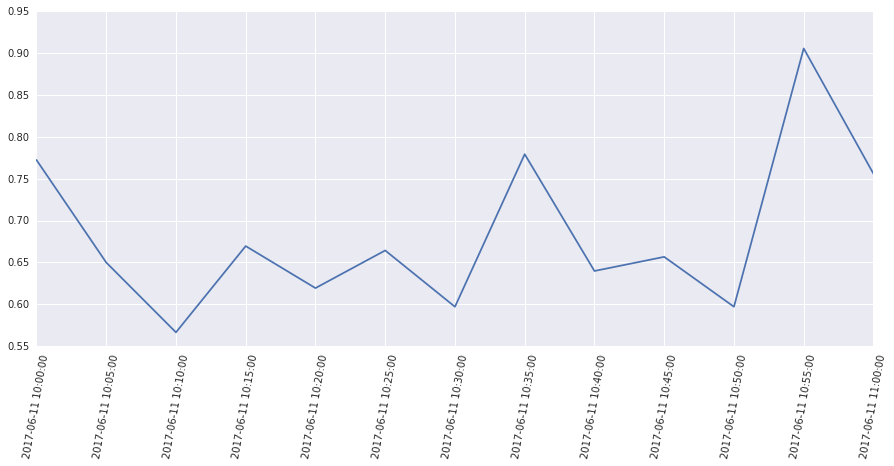

In [60]:
import matplotlib.pyplot as pplt
pplt.plot(calc_ent3['out_degree_entropy'])
pplt.xticks(range(len(calc_ent3['flStDttmEst'])),calc_ent3['flStDttmEst'])
pplt.xticks(rotation=80)
#pplt.autoscale(enable=True, axis='x', tight=None)
pplt.show()

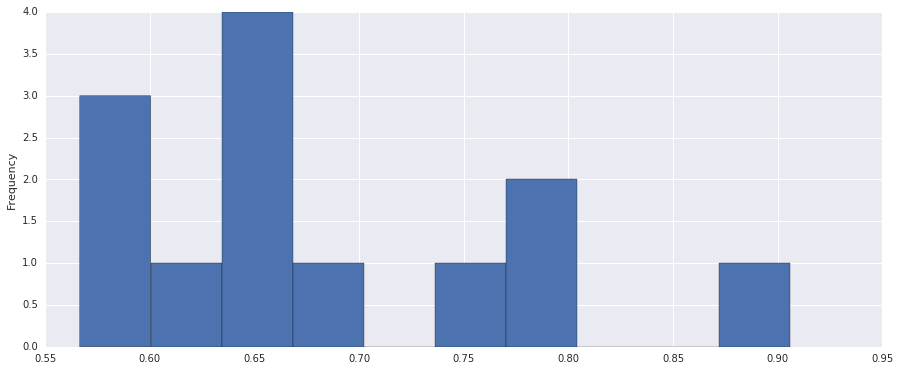

In [61]:
hist_plot = calc_ent3['out_degree_entropy'].plot.hist()

In [80]:
##### Run a correlation to see the relationship between calc_ents indicator features
##### All correlations are statistically significant 
#calc_ent3['unq_src_addr_cnt'] = calc_ent3.unq_src_addr_cnt.astype(int)
#calc_ent3['unq_src_addr_cnt'].dtype

corr1 = pearsonr(calc_ent3['dstAd'],calc_ent3['unq_src_host_count'])
corr2 = pearsonr(calc_ent3['dstAd'],calc_ent3['out_degree_entropy'])
corr3 = pearsonr(calc_ent3['unq_src_host_count'],calc_ent3['out_degree_entropy'])
print("feature correlation = ",corr1)
print("dst_addr_cnt x Entropy = ", corr2)
print("unq_src_host_count x Entropy = ", corr3)

feature correlation =  (-0.029426022981102019, 0.92397661940365261)
dst_addr_cnt x Entropy =  (-0.6951456910314745, 0.0083474121300085302)
unq_src_host_count x Entropy =  (0.20997076881705692, 0.49112787832052884)


In [82]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Create the various feature ARRAYS data type 
x1 = calc_ent3[['dstAd']]
x2 = calc_ent3['unq_src_host_count'] * calc_ent3['dstAd']
x2 = x2.values.reshape(-1,1)
x3 = calc_ent3['unq_src_host_count'] * calc_ent3['xi_cnt']
x3 = x3.values.reshape(-1,1)
y = calc_ent3['out_degree_entropy']

Coefficients: 
 [-0.02918811]
Mean squared error: 0.00
Variance score: 0.48


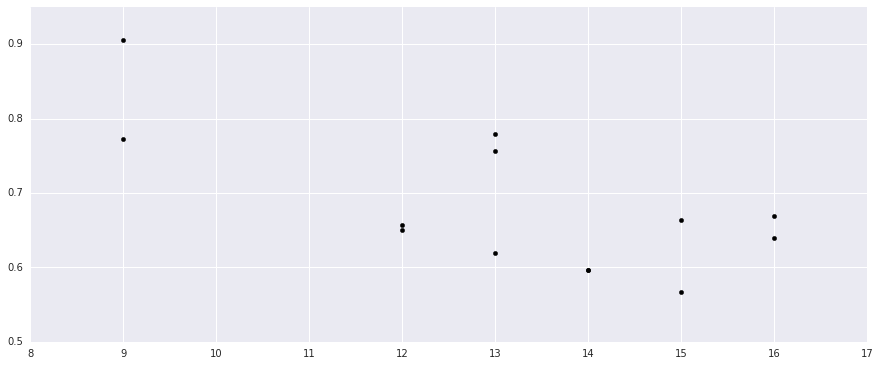

Coefficients: 
 [-0.00375286]
Mean squared error: 0.01
Variance score: 0.13


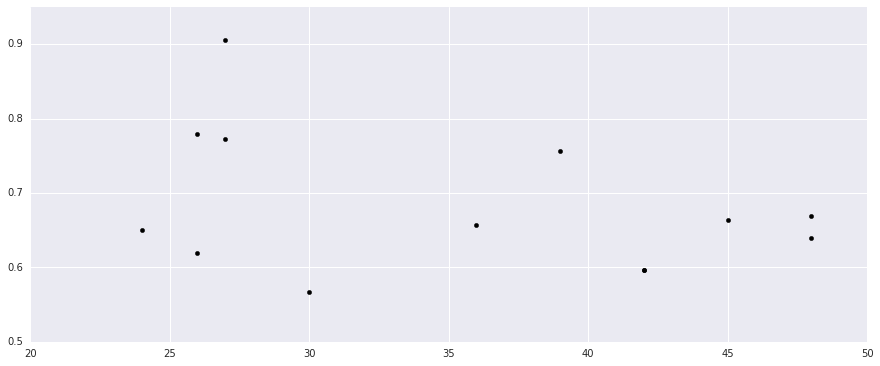

Coefficients: 
 [ 0.00832252]
Mean squared error: 0.01
Variance score: 0.04


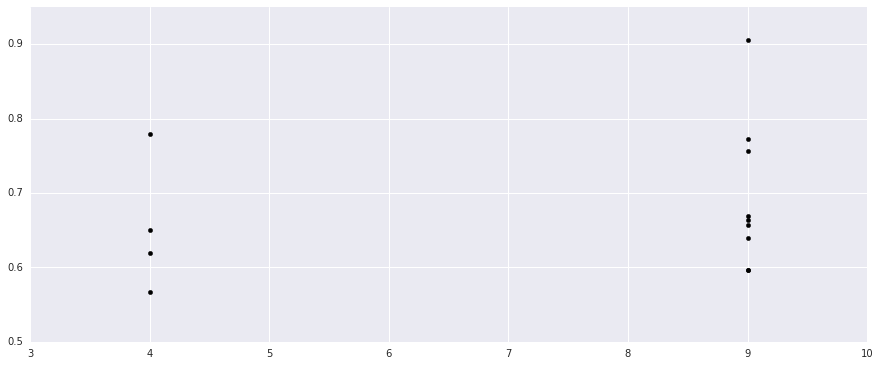

In [84]:
# Fit the Regression Model using the arrays created above
def regression_plots(feature_array):
  regr.fit(feature_array, y)

  # The coefficients
  print('Coefficients: \n', regr.coef_)
  # The mean squared error
  print("Mean squared error: %.2f"
      % np.mean((regr.predict(feature_array) - y) ** 2))
  # Explained variance score: 1 is perfect prediction
  print('Variance score: %.2f' % regr.score(feature_array, y))

  # Plot outputs
  plt.scatter(feature_array, y,  color='black')
  #plt.plot(x1, regr.predict(feature_array), color='blue',
  #       linewidth=3)


  plt.show()
  
regression_plots(x1)
regression_plots(x2)
regression_plots(x3)

In [ ]:
decomposition = seasonal_decompose(calc_ent3.out_degree_entropy.values, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [88]:
calc_ent3.index = calc_ent3['flStDttmEst']
type(calc_ent2['flStDttmEst'])     ### Series

pandas.core.series.Series

In [90]:
model=ARIMA(calc_ent3['out_degree_entropy'],(2,0,0))    ## The endogenous variable needs to be type Float or you get a cast error
model_fit = model.fit()       # fit is a Function
model_fitted = model_fit.fittedvalues    # fittedvalues is a Series
print(model_fit.summary())
print(model_fitted)

                              ARMA Model Results                              
Dep. Variable:     out_degree_entropy   No. Observations:                   13
Model:                     ARMA(2, 0)   Log Likelihood                  12.742
Method:                       css-mle   S.D. of innovations              0.091
Date:                Mon, 10 Jul 2017   AIC                            -17.484
Time:                        19:17:00   BIC                            -15.224
Sample:                    06-11-2017   HQIC                           -17.948
                         - 06-11-2017                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.6778      0.022     30.139      0.000       0.634       0.722
ar.L1.out_degree_entropy    -0.0999      0.308     -0.325      0.752      -0.703       0.

In [ ]:
def create_unistats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}
  
# These are DataFrames
bytes_dist = dfx2['bytes'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()
bytes_dist = bytes_dist[(bytes_dist['dst_port']==53) ]   # all stats are displayed for just port 53

duration_dist = dfx2['duration_ms'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()